# From $d\Sigma/d\Omega(Q)$ to $G(\delta)$ using cosine and Hankel transforms
In this notebook, two numerical methods for computing $G(\delta)$ from the $d\Sigma/d\Omega(Q)$ of a dilute solid sphere sample are derived.  First, $G(\delta)$ is computed using a Hankel transform. Next, a more general method is used to compute $G(\delta)$ by performing the cosine transform once and integrating once. This is equivalent to the Hankel transform for isotropic samples by the projection-slice theorem.

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from hankel import *
from definitions import *

In [134]:
def form_factor(Q, R):
    return (3 * (np.sin(Q * R) - Q * R * np.cos(Q * R))/ (Q * R) ** 3)**2

Sigma * t = 0.06703510527832499 m3


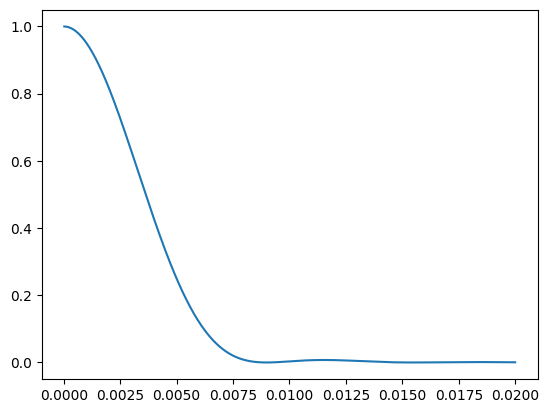

In [135]:
# Sample volume thickness
t = 10e-3 # m
# Radius of sphere, equal to 1 um but expressed in AA
# Volume ratio
phi = 0.015
delta_rho = 1.8e10 * (1e2) ** 2 # 1/m^2 (?)
wavelength = 4.321e-10 # m

R = 50e-9
Q_min = 0.01 / R
Q_max = 10 / R
Q = np.linspace(Q_min, Q_max, 1000)
ff = form_factor(Q,R)
sigma_an = s_t(R,t,wavelength,phi,delta_rho)
plt.plot(Q * 1e-10, ff)
print(f"Sigma * t = {sigma_an} m3")

# Hankel transformation implementation
The implementation closely follows that of the following paper, using straightforward numpy interpretations of the procedure described

Bakker, J. H., Washington, A. L., Parnell, S. R., Van Well, A. A., Pappas, C., & Bouwman, W. G. (2020). Analysis of SESANS data by numerical Hankel transform implementation in SasView. Journal of Neutron Research, 22(1), 57-70. https://doi.org/10.3233/jnr-200154


In [136]:
delta_min = R / 10
delta_max = 3 * R
Z = 250
delta, Qn, dQ, N =setup_Q_delta_arrays(delta_min, delta_max, Z)
H_0, H_kernel = create_hankel_kernels(Qn, dQ, delta, Z)
I_Q = form_factor(Qn,R) * 0.5 * R ** 2
G_full, G_full_0 = compute_G_matrices(I_Q, H_0, H_kernel, Z)
G_delta_num, sigma_t_num = compute_total_G_sigma(G_full, G_full_0)

Text(0.5, 0, '$\\delta$ [nm]')

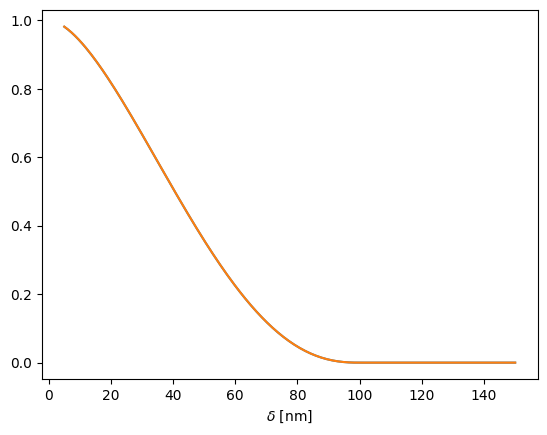

In [137]:
def G_0(xi):
    res = np.zeros_like(xi)
    res[xi>=2.0] = 0
    valid_xi = xi[xi<2.0]
    res[xi<2.0] = np.sqrt(1 - (valid_xi / 2) ** 2) * (1 + valid_xi ** 2 / 8)\
         + 1 / 2 * valid_xi ** 2 * (1 - (valid_xi / 4 ) ** 2) * np.log(valid_xi / (2 + np.sqrt(4 - valid_xi ** 2)))
    return res
G_0_num = G_delta_num / sigma_t_num

xi = delta / R
G_0_an = G_0(xi)
plt.plot(delta * 1e9,G_0_an)
plt.plot(delta * 1e9,G_0_num)
plt.xlabel(r'$\delta$ [nm]')

# Limited $Q$-range effects using Hankel

Text(0.5, 0, '$Q$ [$\\AA^{-1}$]')

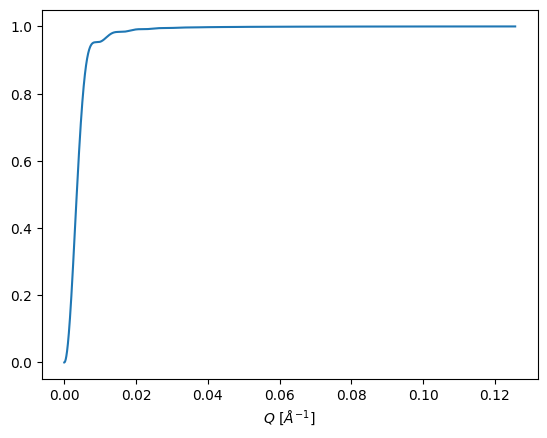

In [138]:
G_partials, sigma_partials, G_0_partial, P_partial = compute_partial_G_sigma(G_full, G_full_0, sigma_t_num, Z)
plt.plot(Qn * 1e-10, sigma_partials)
plt.xlabel(r'$Q$ [$\AA^{-1}$]')

In [139]:
Q_max_plot = 2 * np.pi / R
Q_indices = indices_within_range(Qn,0, Q_max_plot)
Q_max_plot * 1e-10

0.012566370614359173

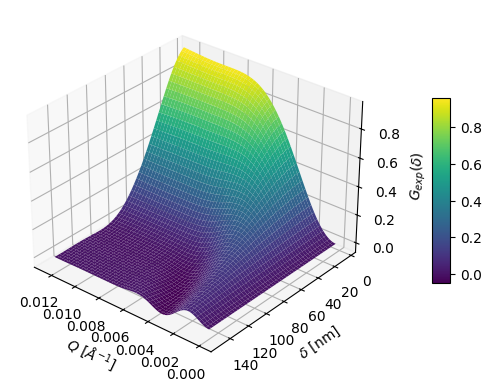

In [140]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(Qn[Q_indices],delta, indexing='ij')
surf = ax.plot_surface(X * 1e-10, Y  * 1e9, G_partials[Q_indices,:], cmap='viridis', edgecolor='none')
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.12)
ax.set_xlabel(r'$Q$ [$\AA^{-1}$]')
ax.set_ylabel(r'$\delta$ [nm]')
ax.set_zlabel(r'$G_{exp}(\delta)$')
ax.view_init(elev=30, azim=130)  # Adjust these values as needed
plt.show()

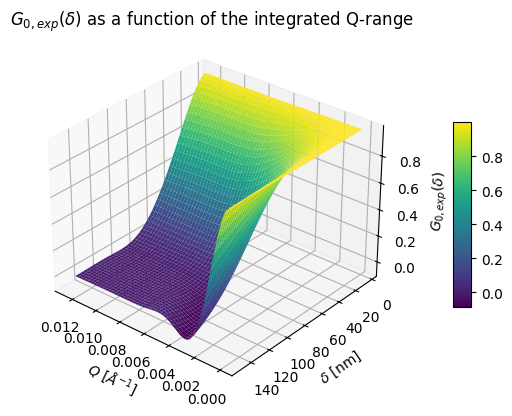

In [141]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(Qn[Q_indices],delta, indexing='ij')

# Supposed to represent


surf = ax.plot_surface(X * 1e-10, Y  * 1e9, G_0_partial[Q_indices], cmap='viridis', edgecolor='none')
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.12)
ax.set_xlabel(r'$Q$ [$\AA^{-1}$]')
ax.set_ylabel(r'$\delta$ [nm]')
ax.set_zlabel(r'$G_{0,exp}(\delta)$')
plt.title(r"$G_{0,exp}(\delta)$ as a function of the integrated Q-range")
ax.view_init(elev=30, azim=130)  # Adjust these values as needed
plt.show()

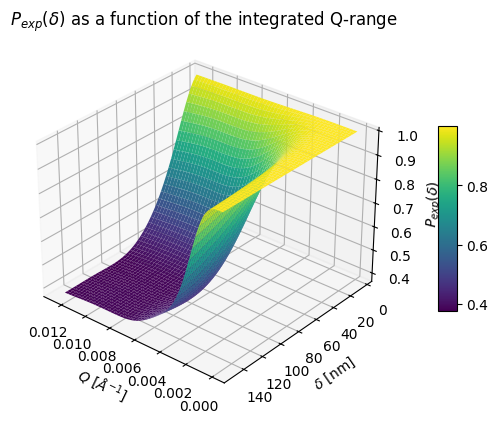

In [142]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(Qn[Q_indices],delta, indexing='ij')

surf = ax.plot_surface(X * 1e-10, Y  * 1e9, P_partial[Q_indices], cmap='viridis', edgecolor='none')
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
ax.set_xlabel(r'$Q$ [$\AA^{-1}$]')
ax.set_ylabel(r'$\delta$ [nm]')
plt.title(r"$P_{exp}(\delta)$ as a function of the integrated Q-range")
ax.set_zlabel(r'$P_{exp}(\delta)$')
ax.view_init(elev=30, azim=130)  # Adjust these values as needed
plt.show()

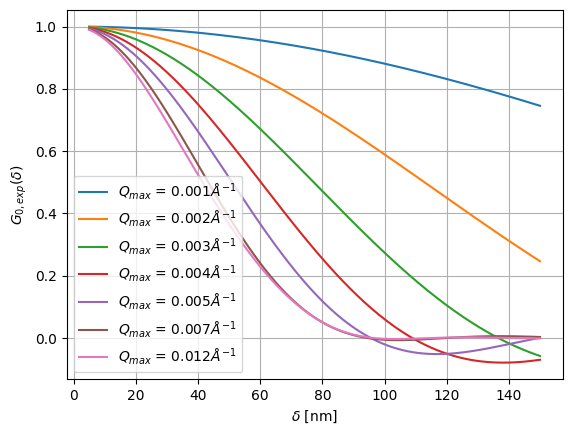

In [143]:
def get_Q_ix(Q):
  return int(Q/dQ)

Q_lims = [0.001e10, 0.002e10, 0.003e10, 0.004e10, 0.005e10, 0.007e10, 0.012e10]
for Q_lim in Q_lims:
  plt.plot(delta * 1e9, G_0_partial[get_Q_ix(Q_lim),:], label=r'$Q_{max}$ = ' + str(Q_lim * 1e-10) + r'$\AA^{-1}$')
  plt.xlabel(r'$\delta$ [nm]')
  plt.ylabel(r'$G_{0,exp}(\delta)$')
plt.legend()
plt.grid()

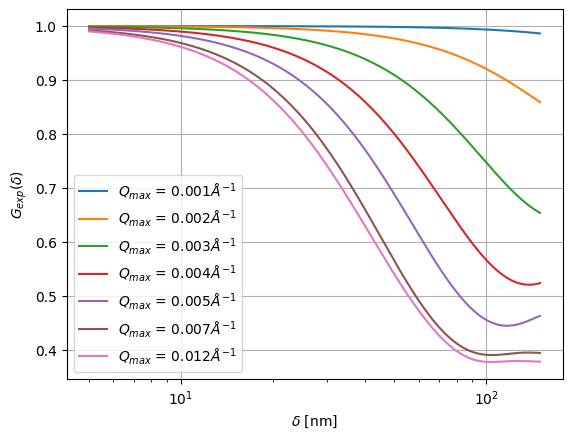

In [144]:
for Q_lim in Q_lims:
  plt.plot(delta * 1e9, P_partial[get_Q_ix(Q_lim),:], label=r'$Q_{max}$ = ' + str(Q_lim * 1e-10) + r'$\AA^{-1}$')
plt.xlabel(r'$\delta$ [nm]')
plt.ylabel(r'$G_{exp}(\delta)$')
plt.legend()
plt.grid()
plt.xscale('log')

# $G(\delta)$ from projection and cosine transform

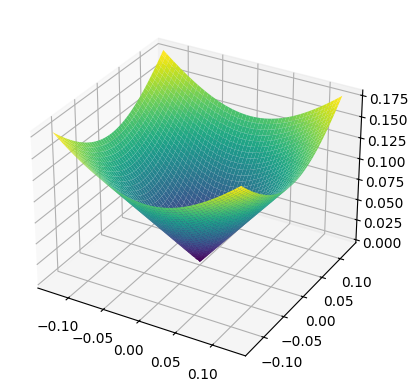

In [180]:
def setup_Q_delta_arrays(delta_min, delta_max, Z, Q_max = None):
    delta = np.linspace(delta_min, delta_max, Z)
    Q_max_delta = 2 * np.pi / delta_min
    if Q_max is None:
        Q_max = Q_max_delta
    else:
        Q_max = np.min((Q_max_delta, Q_max))
    dQ = 0.1 * 2 * np.pi / (Z * (delta_max - delta_min))
    N = int(np.ceil(Q_max / dQ))
    Qn = np.arange(-N,N+1) * dQ
    Qx, Qy = np.meshgrid(Qn, Qn)
    Q = np.sqrt(Qx**2 + Qy**2)
    return delta, Qn, dQ, N, Qx, Qy, Q

R = 50e-9
delta_min = R / 10
delta_max = 2.5 * R
Z = 18

delta, Qn, dQ, N, Qx, Qy, Q =setup_Q_delta_arrays(delta_min, delta_max, Z, None)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Qx * 1e-10, Qy * 1e-10, Q * 1e-10, cmap='viridis', edgecolor='none')

/tmp/ipykernel_23444/3127311077.py:2: RuntimeWarning: invalid value encountered in divide
  return (3 * (np.sin(Q * R) - Q * R * np.cos(Q * R))/ (Q * R) ** 3)**2


7.067015220127722


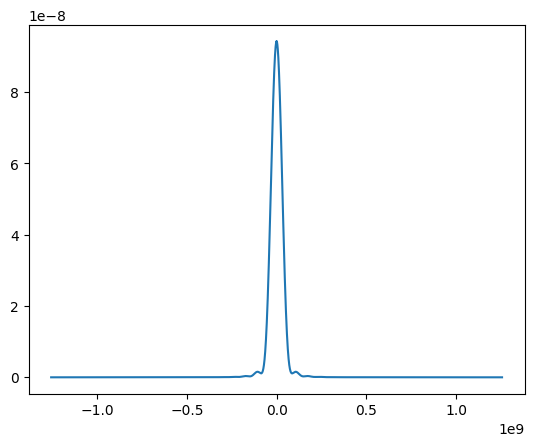

In [181]:
from scipy import integrate

def clean_nan(x):
    nan_ix = np.isnan(x)
    x[nan_ix] = 0
    return x

I_Q = clean_nan(form_factor(Q,R) * 0.5 * R ** 2)
I_Q_x_integ = integrate.trapezoid(I_Q, dx = dQ, axis = 0)
sigma_t = integrate.trapezoid(I_Q_x_integ, dx = dQ, axis = 0)
plt.plot(Qn, I_Q_x_integ)
print(sigma_t)

(8641, 18)


Text(0, 0.5, '$F(\\delta)$')

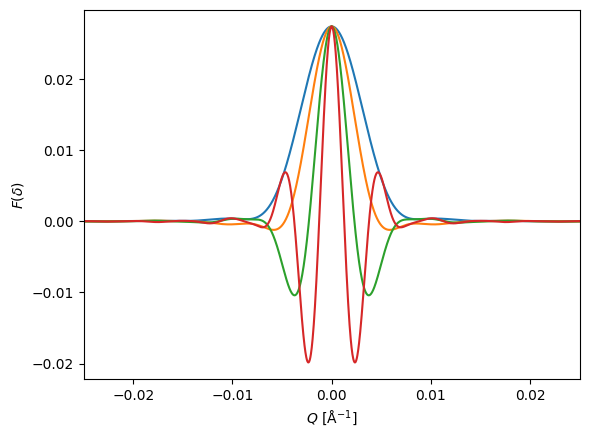

In [182]:
cos_Qy_delta = np.cos(np.outer(Qn,delta))
print(cos_Qy_delta.shape)
I_Q_mat = np.tile(I_Q_x_integ, (Z,1)).transpose()
F_kernel = cos_Qy_delta * I_Q_mat * dQ
# print(F_kernel, F_kernel.shape)

for i in [0,int(Z/4),int(Z/2),Z-1]:
    plt.plot(Qn * 1e-10, F_kernel[:,i])
plt.xlim((-0.025,0.025))
plt.xlabel(r'$Q$ [Å$^{-1}$]')
plt.ylabel(r'$F(\delta)$')

Text(0, 0.5, '$G_0(\\delta)$')

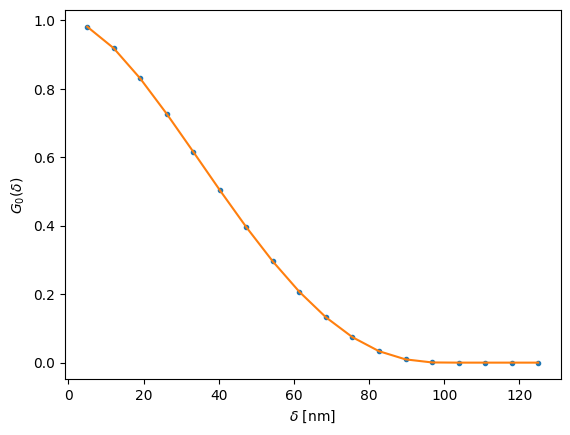

In [183]:
G_integ = np.sum(F_kernel,axis=0)
G_0_integ = G_integ / sigma_t
plt.plot(delta * 1e9, G_0_integ, '.')
xi = delta / R
G_0_an = G_0(xi)
plt.plot(delta * 1e9,G_0_an)
plt.xlabel(r'$\delta$ [nm]')
plt.ylabel(r'$G_0(\delta)$')

# Limited $Q$-range effects using Fourier and projection

/tmp/ipykernel_23444/3127311077.py:2: RuntimeWarning: invalid value encountered in divide
  return (3 * (np.sin(Q * R) - Q * R * np.cos(Q * R))/ (Q * R) ** 3)**2


7.0670485484292 4.900257435721178


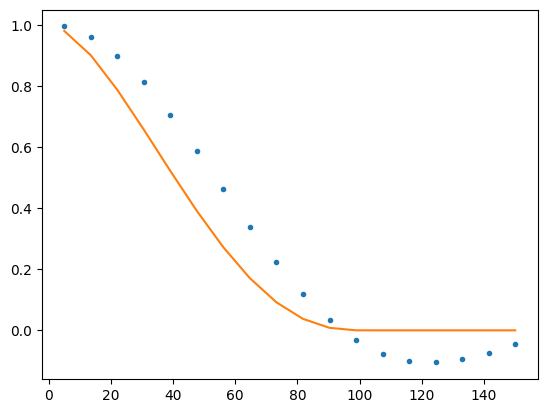

In [186]:
def compute_total_sigma(R, Z):
    delta_min = R / 10
    delta_max = 3.0 * R
    _, Qn, _, _, _, _, _ =setup_Q_delta_arrays(delta_min, delta_max, Z, None)
    Qx, Qy = np.meshgrid(Qn, Qn)
    Q = np.sqrt(Qx**2 + Qy**2)
    I_Q = clean_nan(form_factor(Q,R) * 0.5 * R ** 2)
    I_Q_x_integ = integrate.trapezoid(I_Q, dx = dQ, axis = 0)
    sigma_t = integrate.trapezoid(I_Q_x_integ, dx = dQ, axis = 0)
    return sigma_t

delta_min = R / 10
delta_max = 3.0 * R
sigma_t_absolute = compute_total_sigma(R,Z)
Q_max = 0.004039179014103979e10
delta, Qn, dQ, N, Qx, Qy, Q = setup_Q_delta_arrays(delta_min, delta_max, Z, Q_max)

I_Q = clean_nan(form_factor(Q,R) * 0.5 * R ** 2)

# Compute integrals and sigma_t
I_Q_x_integ = integrate.trapezoid(I_Q, dx = dQ, axis = 0)
sigma_t = integrate.trapezoid(I_Q_x_integ, dx = dQ, axis = 0)

# Compute cosine transform
cos_Qy_delta = np.cos(np.outer(Qn,delta))
I_Q_mat = np.tile(I_Q_x_integ, (Z,1)).transpose()
F_kernel = cos_Qy_delta * I_Q_mat * dQ

G_integ = np.sum(F_kernel,axis=0)
G_0_integ = G_integ / sigma_t
# print(sigma_t)
plt.plot(delta * 1e9, G_0_integ, '.')
xi = delta / R
G_0_an = G_0(xi)
plt.plot(delta * 1e9,G_0_an)
print(sigma_t_absolute, sigma_t)

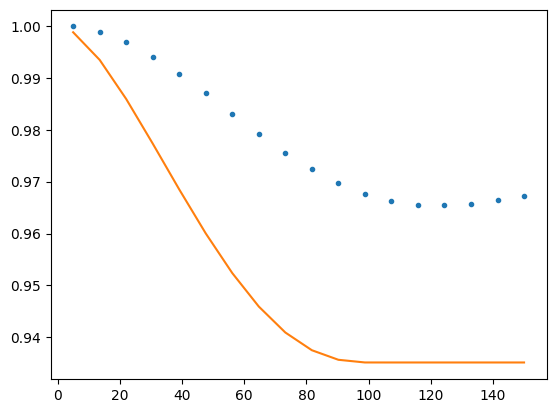

In [185]:
sigma_an = s_t(R,t,wavelength,phi,delta_rho)
P_an = np.exp(sigma_an * (G_0_an - 1))
P_part = np.exp(sigma_t/sigma_t_absolute * sigma_an *(G_0_integ - 1))
plt.plot(delta * 1e9, P_part, '.')
plt.plot(delta * 1e9,P_an)